In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")


# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder


We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = []

while len(line)!=0:
    questions.append(line.strip())
    line = f.readline()
    
questions = questions[1:-1]

# A) Preprocessing

In [4]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
#gpt_answers.head(3)

In [5]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [6]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [7]:
for q_nb, question in enumerate(questions):
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

In [8]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

#plot(gpt_answers)

In [9]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
#plot_pie_charts(gpt_answers)

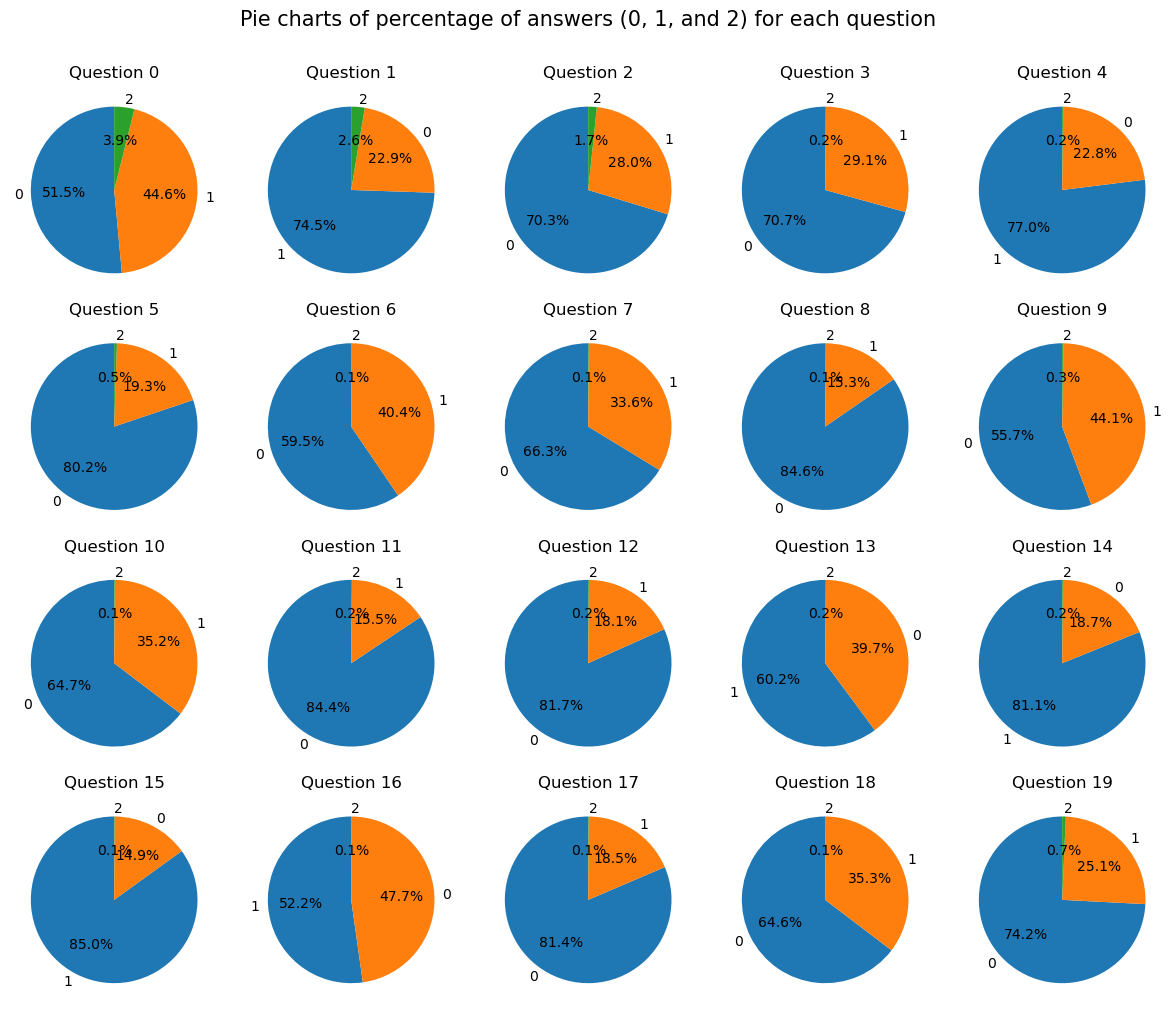

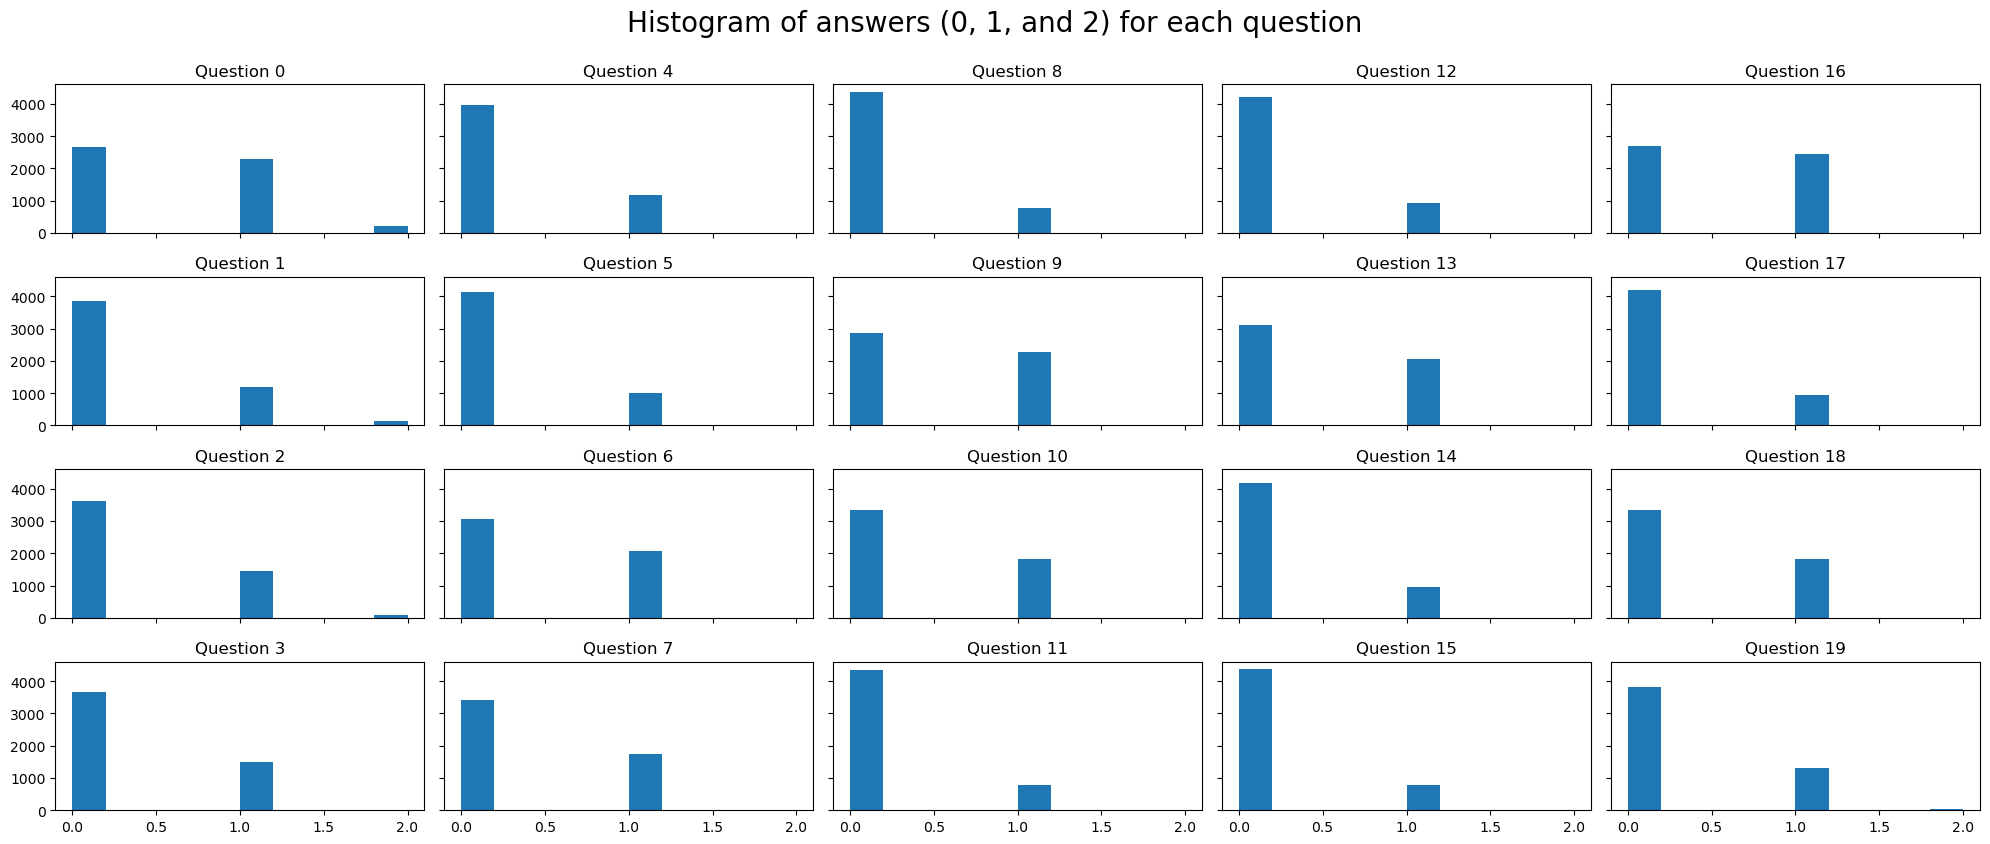

In [10]:
relevant_answers = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()
relevant_answers2 = relevant_answers[relevant_answers['binary_answers'].str.contains('1')].copy()
plot_pie_charts(relevant_answers2)
plot(relevant_answers2)

In [11]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
#right merge because we only care about the relevant answers
gpt_year = romance_with_binary.merge(relevant_answers2, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

We now have `relevant_answers` which consists of all movies we can analyze.

# B) Analysis of single questions

In [12]:
trimmed = relevant_answers2.drop(['binary_answers'], axis = 1)
trimmed = trimmed.replace(2, np.NaN)
df = trimmed.merge(romance_with_binary, on = 'movie_id', how = 'left')
display(df)

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3960327.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,6.0,8597.0,01000000000111011000
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,3600000.0,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,5.6,1003.0,00010011010001001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,6.1,1313.0,00010100010001000000
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2158775.0,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,6.9,17890.0,00001000110110100010
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,288752301.0,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,7.1,218787.0,10000000001000010010
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,6.8,6422.0,00000001010000000000


In [13]:
df["ratings_with_weight"] = [ v + w*1j for v,w in zip(df.rating, df.nb_votes)]
def weighted_mean(x, **kws):
    return np.sum(np.real(x) * np.imag(x)) / np.sum(np.imag(x))

display(df)


#def weighted_mean(x, **kws):
#    val, weight = map(np.asarray, zip(*x))
#    return (val * weight).sum() / weight.sum()

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers,ratings_with_weight
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000,5.8+10129.00j
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100,6.1+0545.00j
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000,6.4+10240.00j
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,6.0,8597.0,01000000000111011000,6.0+80597.00j
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,5.6,1003.0,00010011010001001000,5.6+10003.00j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,6.1,1313.0,00010100010001000000,6.1+10313.00j
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,6.9,17890.0,00001000110110100010,6.9+17890.0j
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,7.1,218787.0,10000000001000010010,7.1+218787.0j
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,6.8,6422.0,00000001010000000000,6.8+60422.00j


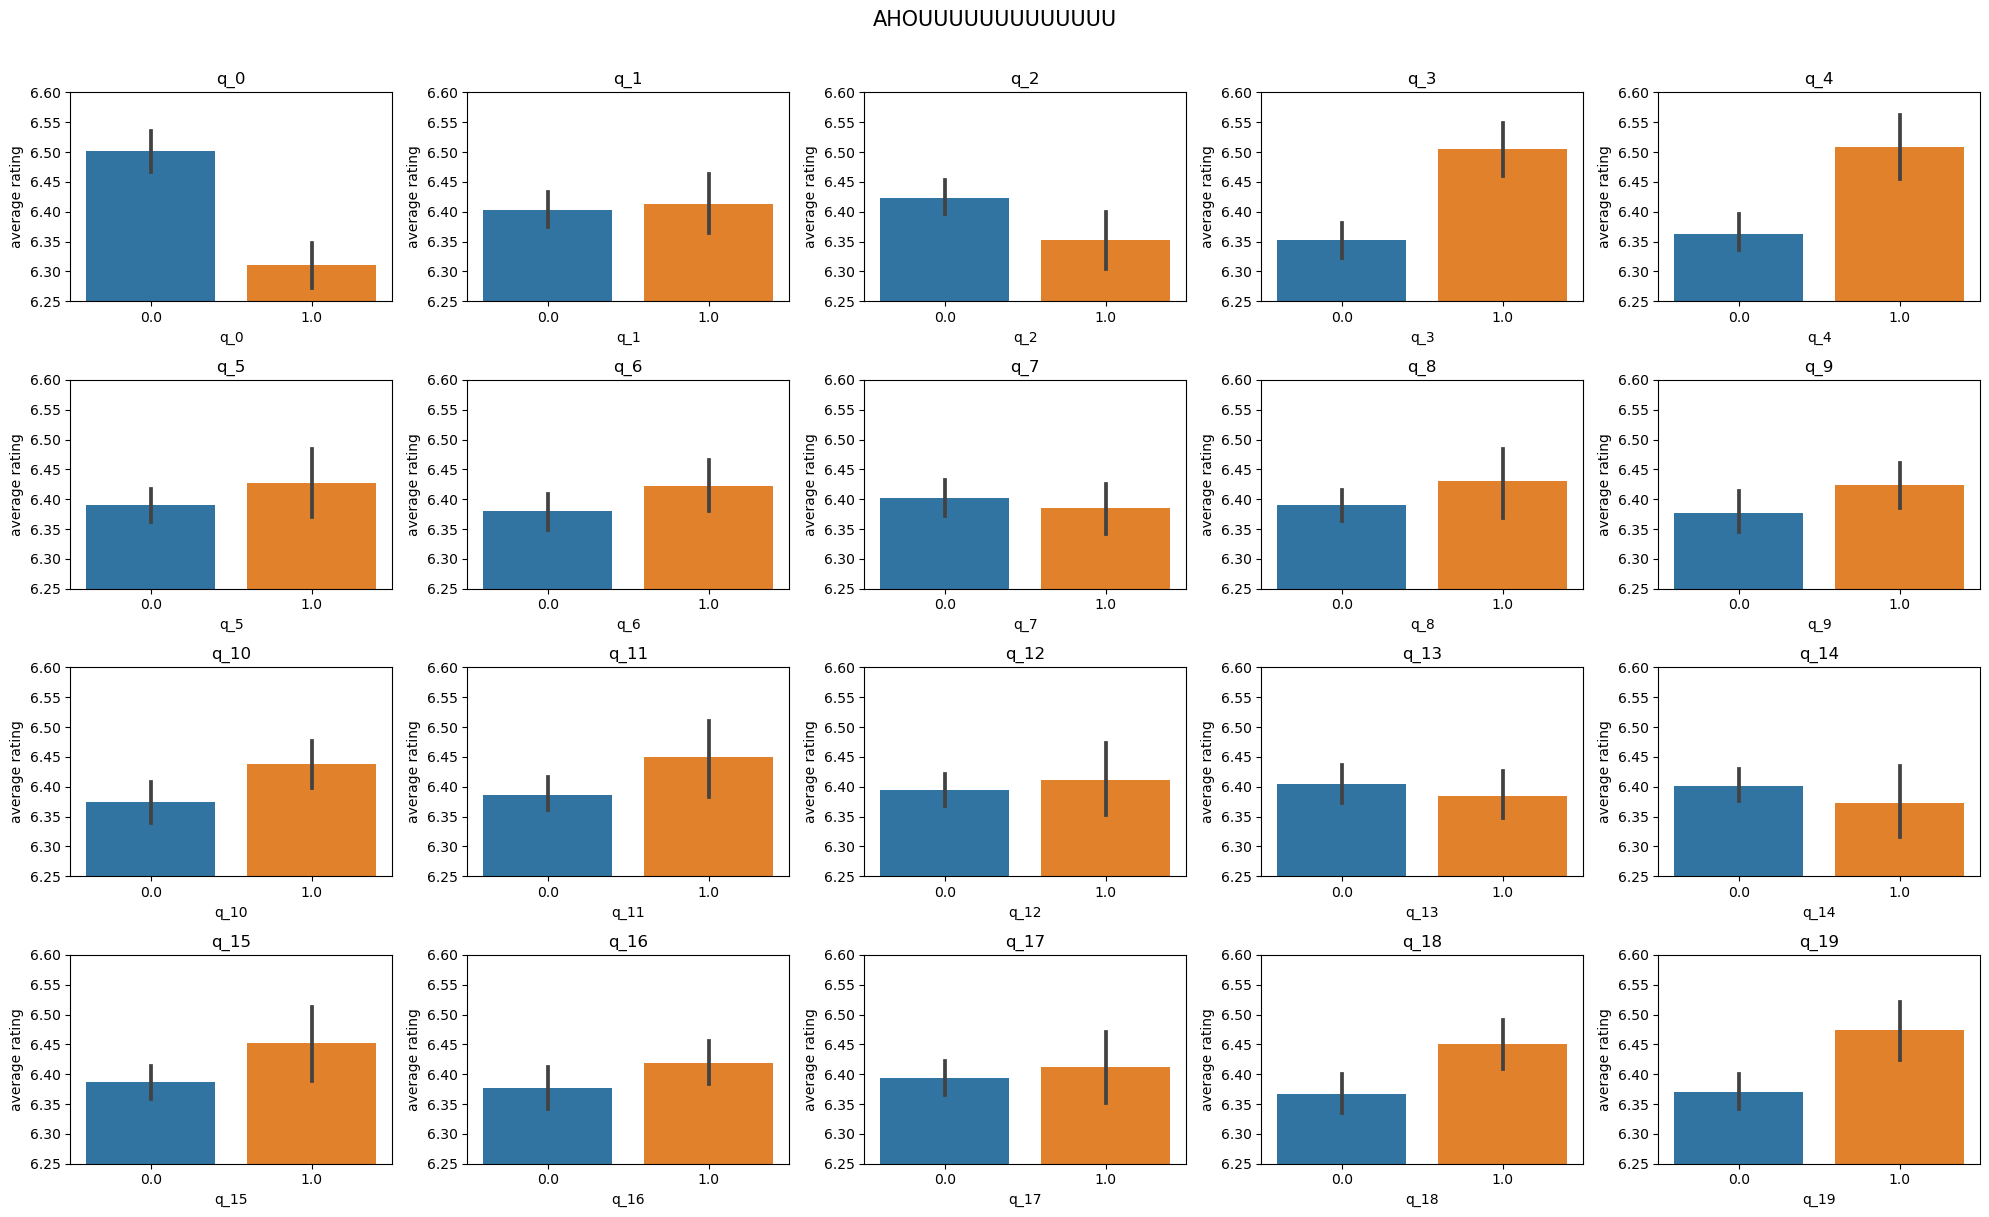

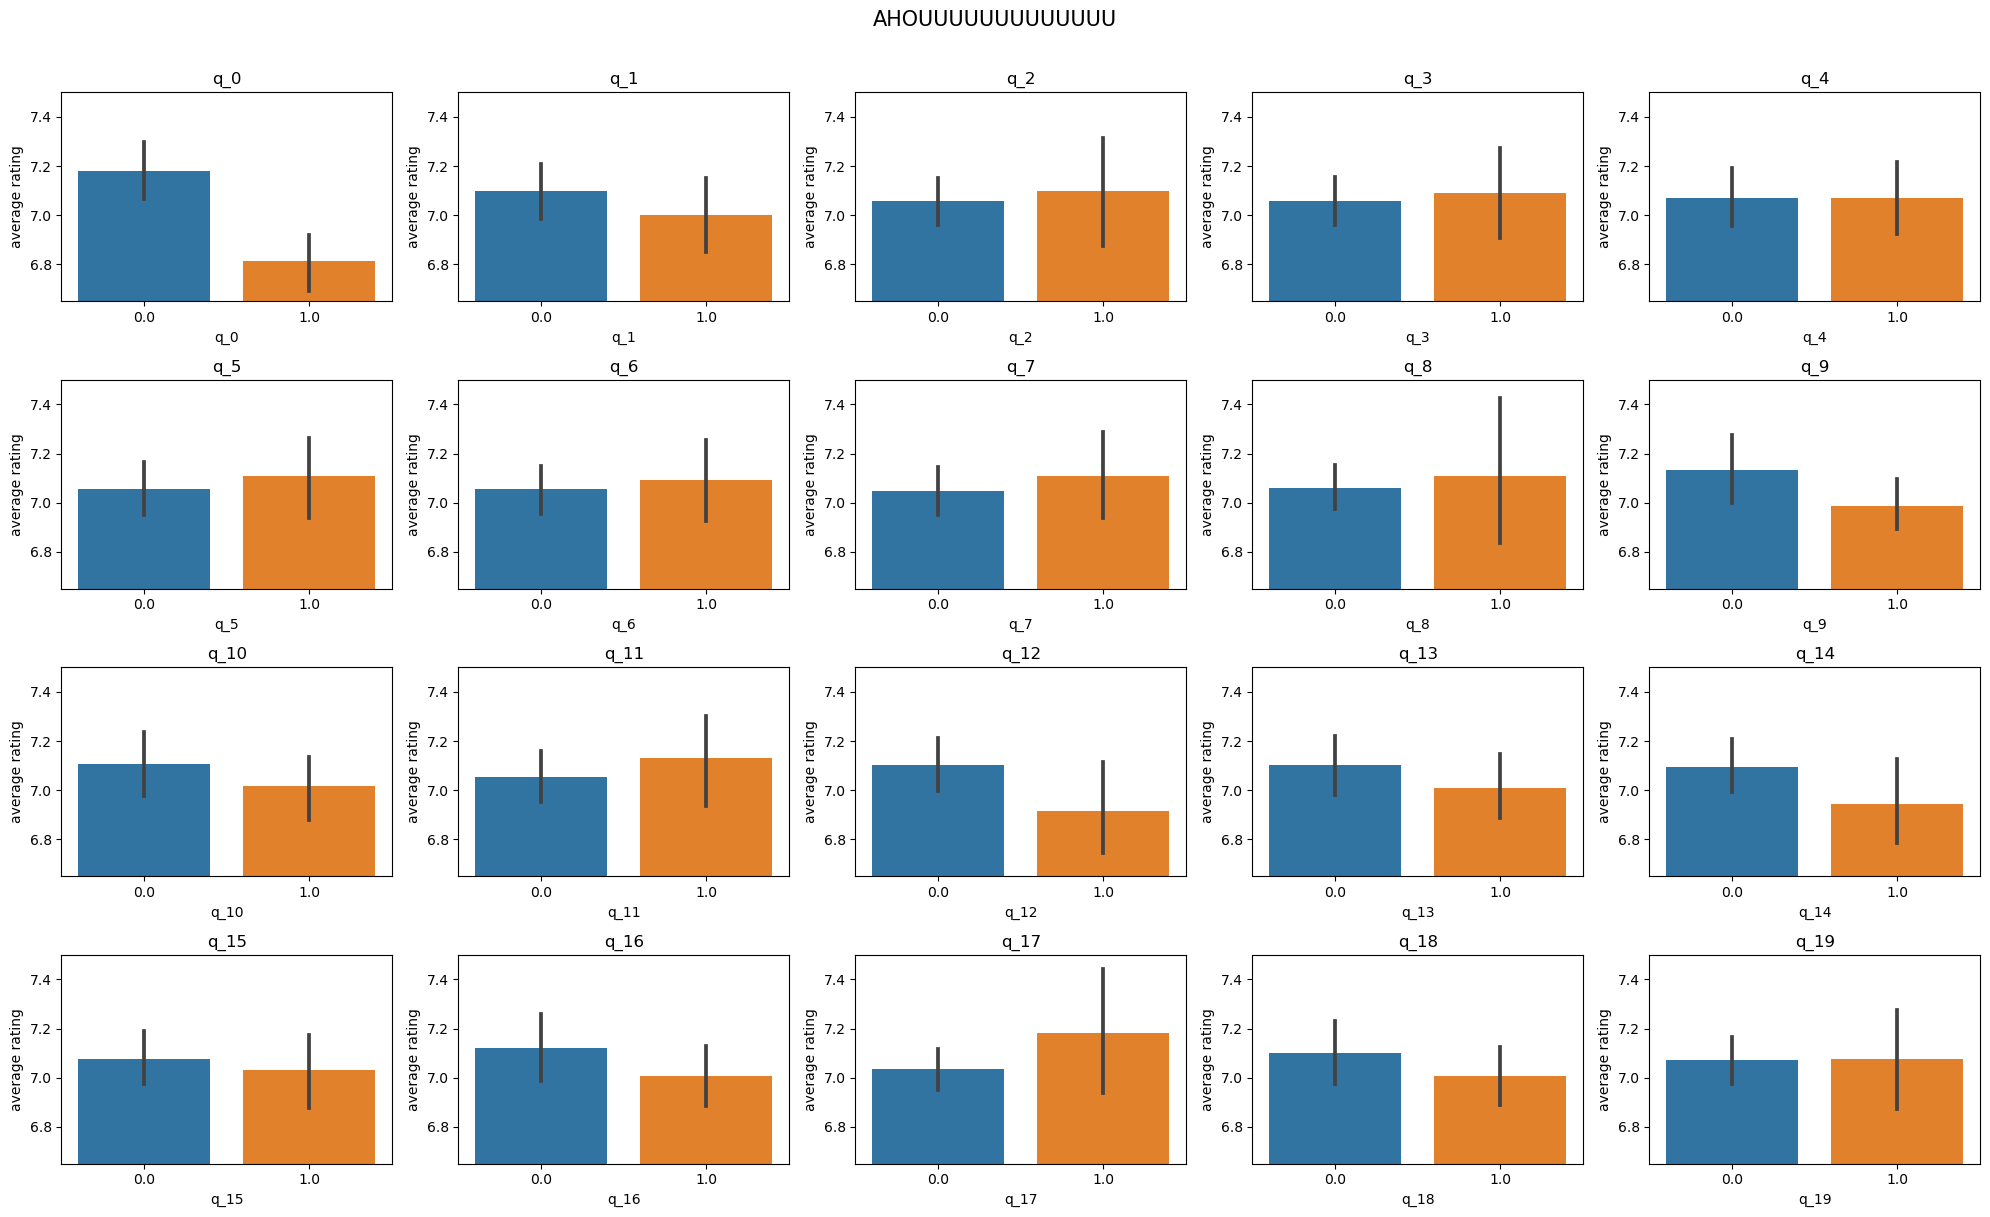

In [14]:
def plot_error_bars(df, nr_rows, nr_cols, weights):
    
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
    
    for r in range(nr_rows):
        for c in range(nr_cols):
            
            index = r * 5 + c
            question = 'q_' + str(index)
            
            if weights : 
                sns.barplot(df, x= question, y='ratings_with_weight', ax = ax[r][c], estimator = weighted_mean, errorbar=('ci', 95))
                ax[r][c].set_ylim(6.65,7.5)
            else :
                sns.barplot(df, x= question, y='rating', ax = ax[r][c])
                ax[r][c].set_ylim(6.25,6.6)

            ax[r][c].set_ylabel('average rating')
            ax[r][c].set_title(question)
            #ax[r,c].set_title(question)
    
    fig.suptitle('AHOUUUUUUUUUUUUU', y=1.01, fontsize=15)
    plt.tight_layout()    
    plt.show()
            
        
        
plot_error_bars(df,4,5, False)
plot_error_bars(df,4,5, True)
#for i in range(19) :
#    sns.barplot(new_df, x= 'q_18', y='rating')
#plt.ylim(6.1,6.6)

# C) Analysis of ratings

In [15]:
display(df)

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers,ratings_with_weight
0,6631279,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000,5.8+10129.00j
1,21926710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100,6.1+0545.00j
2,26067101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000,6.4+10240.00j
3,12053509,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1989.0,"['Comedy', 'Romance']",tt0097790,6.0,8597.0,01000000000111011000,6.0+80597.00j
4,7028314,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,90.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1957.0,"['Comedy', 'Romance']",tt0050646,5.6,1003.0,00010011010001001000,5.6+10003.00j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,4037444,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,100.0,{'/m/01gp_d': 'Finnish Language'},"{'/m/02vzc': 'Finland', '/m/0d0vqn': 'Sweden'}",2004.0,"['Comedy', 'Romance', 'LGBT', 'World Cinema', ...",tt0366701,6.1,1313.0,00010100010001000000,6.1+10313.00j
5255,1191380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,118.0,{'/m/02h40lc': 'English Language'},"{'/m/014tss': 'Kingdom of Great Britain', '/m/...",1997.0,"['Romance', 'Biopic', 'History', 'LGBT', 'Worl...",tt0120514,6.9,17890.0,00001000110110100010,6.9+17890.0j
5256,54540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1988.0,"['Drama', 'Comedy', 'Romance']",tt0094898,7.1,218787.0,10000000001000010010,7.1+218787.0j
5257,1673588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,104.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},1984.0,"['Comedy', 'Romance', 'Indie', 'Religious', 'F...",tt0087004,6.8,6422.0,00000001010000000000,6.8+60422.00j


In [16]:
df.columns

Index(['movie_id', 'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7',
       'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16',
       'q_17', 'q_18', 'q_19', 'index', 'movie_name', 'revenue', 'runtime',
       'languages', 'countries', 'movie_release', 'genres', 'imdb_id',
       'rating', 'nb_votes', 'binary_answers', 'ratings_with_weight'],
      dtype='object')

In [17]:
df['revenue'].isna().sum() # 3403 # numeric
df['runtime'].isna().sum() # 199 # numeric
df['movie_release'].isna().sum() # 0 # numeric
df['rating'].isna().sum() # 0 # numeric
df['nb_votes'].isna().sum() # 0 # numeric

0

In [18]:
df['q_0'].isna().sum() # 205 
df['q_1'].isna().sum() # 136 
df['q_2'].isna().sum() # 87 
df['q_3'].isna().sum() # 8 
df['q_4'].isna().sum() # 10 
df['q_5'].isna().sum() # 27 
df['q_6'].isna().sum() # 6 
df['q_7'].isna().sum() # 7 
df['q_8'].isna().sum() # 7 
df['q_9'].isna().sum() # 13     
df['q_10'].isna().sum() # 7 
df['q_11'].isna().sum() # 9 
df['q_12'].isna().sum() # 8 
df['q_13'].isna().sum() # 8 
df['q_14'].isna().sum() # 8 
df['q_15'].isna().sum() # 5 
df['q_16'].isna().sum() # 5 
df['q_17'].isna().sum() # 6 
df['q_18'].isna().sum() # 5 
df['q_19'].isna().sum() # 37 

37

In [19]:
normalized_df=df.copy()
normalized_df = normalized_df.drop(['movie_id', 'index', 'movie_name', 'languages', 'countries', 'genres', 'imdb_id', 'ratings_with_weight', 'binary_answers'], axis=1)
normalized_df.columns

Index(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
       'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18',
       'q_19', 'revenue', 'runtime', 'movie_release', 'rating', 'nb_votes'],
      dtype='object')

In [20]:
# normalizations min-max
normalized_df['revenue'] = (normalized_df['revenue'] - normalized_df['revenue'].min()) / (normalized_df['revenue'].max() - normalized_df['revenue'].min())
normalized_df['runtime'] = (normalized_df['runtime'] - normalized_df['runtime'].min()) / (normalized_df['runtime'].max() - normalized_df['runtime'].min())
normalized_df['movie_release'] = (normalized_df['movie_release'] - normalized_df['movie_release'].min()) / (normalized_df['movie_release'].max() - normalized_df['movie_release'].min())
normalized_df['rating'] = (normalized_df['rating'] - normalized_df['rating'].min()) / (normalized_df['rating'].max() - normalized_df['rating'].min())
normalized_df['nb_votes'] = (normalized_df['nb_votes'] - normalized_df['nb_votes'].min()) / (normalized_df['nb_votes'].max() - normalized_df['nb_votes'].min())

In [21]:
# remove nan in questions
print(normalized_df.shape)
normalized_df_questions = normalized_df.dropna(subset=['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19']).copy()
normalized_df_runtime = normalized_df_questions.dropna(subset=['runtime']).copy()
normalized_df_revenue = normalized_df_questions.dropna(subset=['revenue']).copy()
normalized_df_all = normalized_df_questions.dropna(subset=['runtime', 'revenue']).copy()
normalized_df_no_questions = normalized_df.dropna(subset=['runtime', 'revenue']).copy()

print('drop nan questions :', np.shape(normalized_df_questions))
print('drop nan quesitions + runtime :', np.shape(normalized_df_runtime))
print('drop nan questions + revenue :', np.shape(normalized_df_revenue))
print('drop nan all :', np.shape(normalized_df_all))


# prepare dataframe for later
normalized_df_questions = normalized_df_questions.drop(['revenue', 'runtime'], axis=1)
normalized_df_questions_only = normalized_df_questions.drop(['movie_release', 'nb_votes'], axis=1)
normalized_df_runtime = normalized_df_runtime.drop(['revenue'], axis=1)
normalized_df_revenue = normalized_df_revenue.drop(['runtime'], axis=1)
normalized_df_no_questions = normalized_df_no_questions.drop(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19'], axis=1)

print('questions :', np.shape(normalized_df_questions))
print('only questions :', np.shape(normalized_df_questions_only))
print('quesitions + runtime :', np.shape(normalized_df_runtime))
print('questions + revenue :', np.shape(normalized_df_revenue))
print('all :', np.shape(normalized_df_all))
print('no questions :', np.shape(normalized_df_no_questions))

(5259, 25)
drop nan questions : (5008, 25)
drop nan quesitions + runtime : (4820, 25)
drop nan questions + revenue : (1818, 25)
drop nan all : (1813, 25)
questions : (5008, 23)
only questions : (5008, 21)
quesitions + runtime : (4820, 24)
questions + revenue : (1818, 24)
all : (1813, 25)
no questions : (1851, 5)


> normalized_df_questions --> questions, date and vote \
normalized_df_questions_only --> questions \
normalized_df_runtime --> questions, date, vote, and runtine \
normalized_df_revenue --> questions, date, vote, and revenu \
normalized_df_no_questions --> date, vote, runtime, revenue \
normalized_df_all --> questions, date, vote, runtime, revenu 

# Regression

In [22]:
# virer les question 14 et 15, GPT est perdu

In [23]:
mod0 = smf.ols(formula='rating ~ revenue + runtime + movie_release + nb_votes', data=normalized_df) # 5259
#print(mod0.fit().summary()) # R² = 0.255

# without questions and nan 
mod02 = smf.ols(formula='rating ~ revenue + runtime + movie_release + nb_votes', data=normalized_df_no_questions) # 1851
print(mod02.fit().summary()) # R² = 0.255

# without nan 
mod01 = smf.ols(formula='rating ~ revenue + runtime + movie_release + nb_votes', data=normalized_df_all) # 1813
#print(mod01.fit().summary()) # R² = 0.258

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     158.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          5.57e-117
Time:                        11:32:21   Log-Likelihood:                 1578.8
No. Observations:                1851   AIC:                            -3148.
Df Residuals:                    1846   BIC:                            -3120.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6083      0.017     35.942

In [24]:
mod1 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_14 + q_15 + q_16 + q_17 + q_18 + q_19', data=normalized_df)
#print(mod1.fit().summary()) # R² = 0.025

# without nan
mod11 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_14 + q_15 + q_16 + q_17 + q_18 + q_19', data=normalized_df_questions)
#print(mod11.fit().summary()) # R² = 0.025

# without questions 14 and 15
mod12 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_16 + q_17 + q_18 + q_19', data=normalized_df_questions)
#print(mod12.fit().summary()) # R² = 0.025

# selection of questions with pca results
mod13 = smf.ols(formula='rating ~ q_0 + q_6 + q_9 + q_13 + q_16 + q_18', data=normalized_df_questions)
#print(mod13.fit().summary()) # R² = 0.013

mod14 = smf.ols(formula='rating ~ q_0 + q_6 + q_9 + q_13 + q_18', data=normalized_df_questions)
#print(mod14.fit().summary()) # R² = 0.013

In [25]:
#other selection of questions
# without questions 14 and 15 + (5-17) # celles qui ont 0 dans leur données
mod12 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_18 + q_19', data=normalized_df_questions)
#print(mod12.fit().summary()) # R² = 0.024

# without questions 14 and 15 + (5-17) # celles qui ont 0 dans leur données
mod12 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_6 + q_9 + q_13 + q_18 + q_19', data=normalized_df_questions)
print(mod12.fit().summary()) # R² = 0.025

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     13.82
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.29e-24
Time:                        11:32:21   Log-Likelihood:                 3372.5
No. Observations:                5008   AIC:                            -6723.
Df Residuals:                    4997   BIC:                            -6651.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6783      0.004    176.344      0.0

In [26]:
mod2 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_14 + q_15 + q_16 + q_17 + q_18 + q_19 + revenue + runtime + movie_release + nb_votes', data=normalized_df_all)

#without questions 14 and 15
mod22 = smf.ols(formula='rating ~ q_0 + q_1 + q_2 + q_3 + q_4 + q_5 + q_6 + q_7 + q_8 + q_9 + q_10 + q_11 + q_12 + q_13 + q_16 + q_17 + q_18 + q_19 + revenue + runtime + movie_release + nb_votes', data=normalized_df_all)

#removing questions with coefficients (10, 9, 8, 1, 2, 13, 17, 11)
mod23 = smf.ols(formula='rating ~ q_0 + q_3 + q_4 + q_5 + q_6 + q_7 + q_12 + q_16 + q_18 + q_19 + revenue + runtime + movie_release + nb_votes', data=normalized_df_all)

#removing questions with coefficients (10, 9, 8, 1, 2, 13, 17, 11, 3)
mod24 = smf.ols(formula='rating ~ q_0 + q_4 + q_5 + q_6 + q_7 + q_12 + q_16 + q_18 + q_19 + revenue + runtime + movie_release + nb_votes', data=normalized_df_all)

#print(mod2.fit().summary()) # R² = 0.280 
#print(mod22.fit().summary()) # R² = 0.281 
#print(mod23.fit().summary()) # R² = 0.282
print(mod24.fit().summary()) # R² = 0.281

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     55.49
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.24e-121
Time:                        11:32:21   Log-Likelihood:                 1583.4
No. Observations:                1813   AIC:                            -3139.
Df Residuals:                    1799   BIC:                            -3062.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6176      0.017     35.466

# Random forest

> normalized_df_questions --> questions, date and vote \
normalized_df_questions_only --> questions \
normalized_df_runtime --> questions, date, vote, and runtine \
normalized_df_revenue --> questions, date, vote, and revenu \
normalized_df_no_questions --> date, vote, runtime, revenue \
normalized_df_all --> questions, date, vote, runtime, revenu 

In [27]:
print(normalized_df.shape)

(5259, 25)


In [28]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error, max_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [29]:
regressor = RandomForestRegressor(n_estimators=200, max_depth=20, )
regressor.fit

X_df_question = normalized_df_questions_only[['q_0', 'q_1', 'q_2', 'q_3', 'q_4',
                                               'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 
                                               'q_10', 'q_11', 'q_12', 'q_13', 
                                               'q_14', 'q_15', 'q_16', 'q_17',
                                               'q_18', 'q_19']].copy()
X_df_half_questions = normalized_df_questions_only[['q_0', 'q_1', 'q_2', 'q_3', 
                                                    'q_4', 'q_6', 'q_9', 'q_13',
                                                 'q_16', 'q_18', 'q_19']].copy()
X_df_questions_pca = normalized_df_questions_only[['q_0', 'q_6', 'q_9', 'q_13',
                                                  'q_16', 'q_18']].copy()
y_df_question = normalized_df_questions_only['rating'].copy()


X_df_question_plus = normalized_df_questions[['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 
                                              'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
                                               'q_10', 'q_11', 'q_12', 'q_13', 
                                               'q_14', 'q_15', 'q_16', 'q_17',
                                              'q_18', 'q_19', 'movie_release', 
                                              'nb_votes']].copy()
X_df_half_questions_plus = normalized_df_questions[['q_0', 'q_1', 'q_2', 'q_3',
                                                    'q_4', 'q_6', 'q_9', 'q_13',
                                                 'q_16', 'q_18', 'q_19', 
                                                 'movie_release', 
                                                 'nb_votes']].copy()
X_df_questions_pca_plus = normalized_df_questions[['q_0', 'q_6', 'q_9', 'q_13',
                                                  'q_16', 'q_18', 'movie_release', 
                                                  'nb_votes']].copy()
X_df_plus_without_questions = normalized_df_questions[['movie_release',
                                                         'nb_votes']].copy()
y_df_question_plus = normalized_df_questions['rating'].copy()


X_df_all = normalized_df_all[['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 
                              'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 
                              'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 
                              'q_19', 'movie_release', 'nb_votes', 'runtime', 
                              'revenue']].copy()
X_df_half_all = normalized_df_all[['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_6', 
                                   'q_9', 'q_13', 'q_16', 'q_18', 'q_19', 
                                   'movie_release', 'nb_votes', 'runtime', 
                                   'revenue']].copy()
X_df_all_pca = normalized_df_all[['q_0', 'q_6', 'q_9', 'q_13', 'q_16', 'q_18',
                                  'movie_release', 'nb_votes', 'runtime', 
                                  'revenue']].copy()
X_df_all_without_questions = normalized_df_all[['movie_release', 'nb_votes', 
                                                'runtime', 'revenue']].copy()
y_df_all = normalized_df_all['rating'].copy()


print('1, X_df_question', np.shape(X_df_question), np.shape(y_df_question))
print('2, X_df_question_plus', np.shape(X_df_question_plus), np.shape(y_df_question_plus))
print('5, X_df_all', np.shape(X_df_all), np.shape(y_df_all))


1, X_df_question (5008, 20) (5008,)
2, X_df_question_plus (5008, 22) (5008,)
5, X_df_all (1813, 24) (1813,)


4507 501
5008


(501,)
(501,)


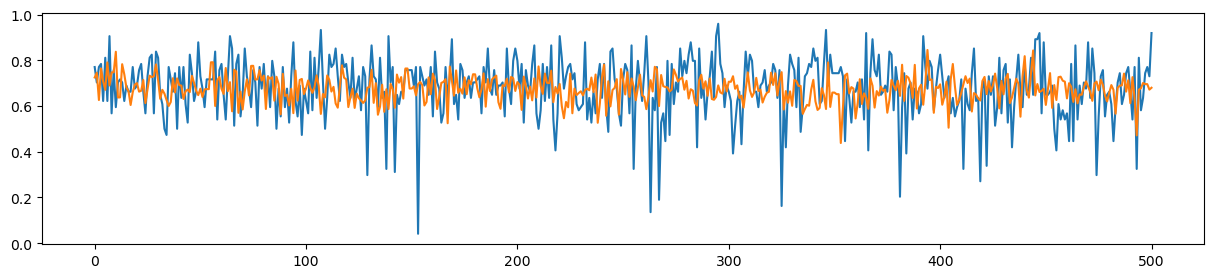

R2 :  -0.208789138649635
RMSE :  0.14422092253649949


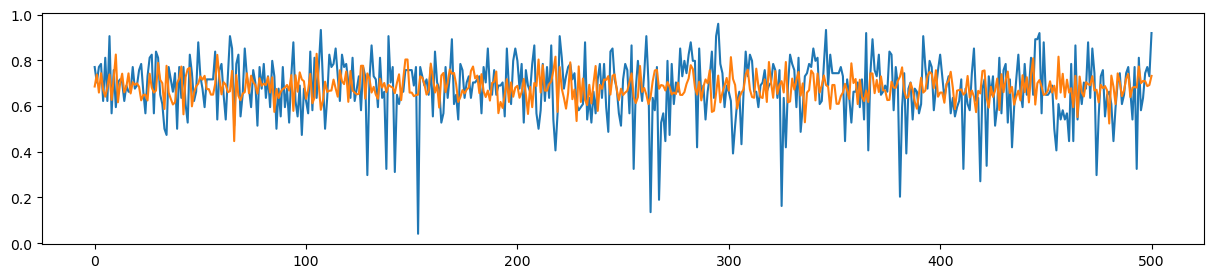

R2 :  -0.13836207191243788
RMSE :  0.13995654197554638


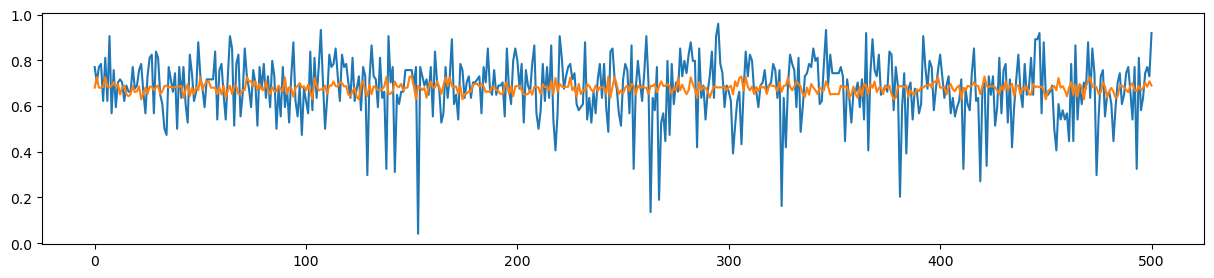

R2 :  -0.01571504925698175
RMSE :  0.1322022779148221


In [30]:
# first version : only questions (X_df_question, y_df_question)

length = len(y_df_question)
train_size = int(length*0.8)
train_size = int(length*0.9)
test_size = length - train_size
print(train_size, test_size)
print(length)

regressor.fit(X_df_question[:train_size], y_df_question[:train_size]) #Set train
y_pred = regressor.predict(X_df_question[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
print(np.shape(x_val))
print(np.shape(y_df_question[train_size:]))


ax.plot(x_val, y_df_question[train_size:])
ax.plot(y_pred)
plt.show()

print("R2 : ",regressor.score(X_df_question[train_size:], y_df_question[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question[train_size:], squared=False)
print("RMSE : ", rmse)

#half questions (X_df_half_questions, y_df_question)
regressor.fit(X_df_half_questions[:train_size], y_df_question[:train_size]) #Set train
y_pred = regressor.predict(X_df_half_questions[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question[train_size:])
ax.plot(y_pred)
plt.show()

print("R2 : ",regressor.score(X_df_half_questions[train_size:], y_df_question[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question[train_size:], squared=False)
print("RMSE : ", rmse)

#questions pca (X_df_questions_pca, y_df_question)
regressor.fit(X_df_questions_pca[:train_size], y_df_question[:train_size]) #Set train
y_pred = regressor.predict(X_df_questions_pca[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question[train_size:])
ax.plot(y_pred)
plt.show()

print("R2 : ",regressor.score(X_df_questions_pca[train_size:], y_df_question[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question[train_size:], squared=False)
print("RMSE : ", rmse)





4507 501
5008


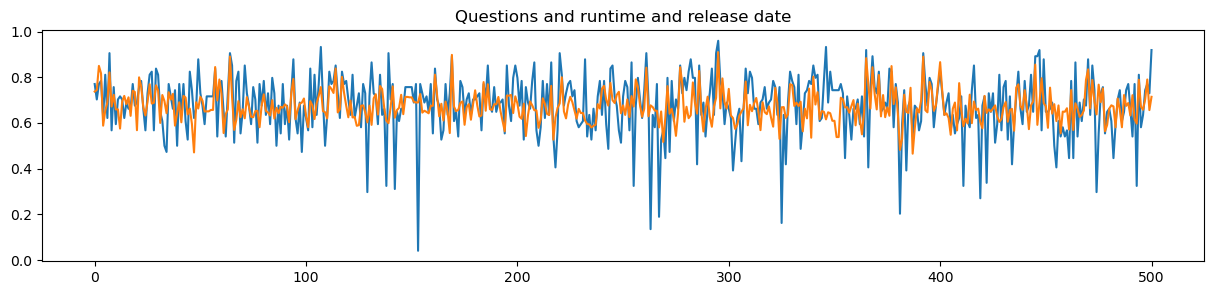

R2 :  0.16081977035637063
RMSE :  0.12016572653613088


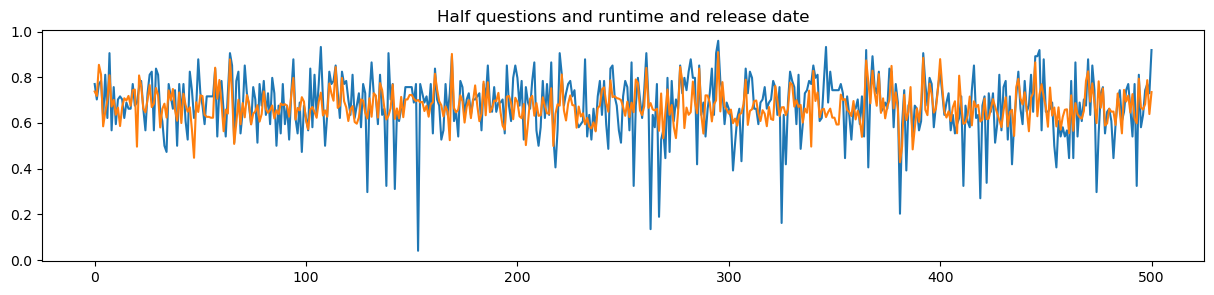

R2 :  0.17538884977214253
RMSE :  0.11911805574677924


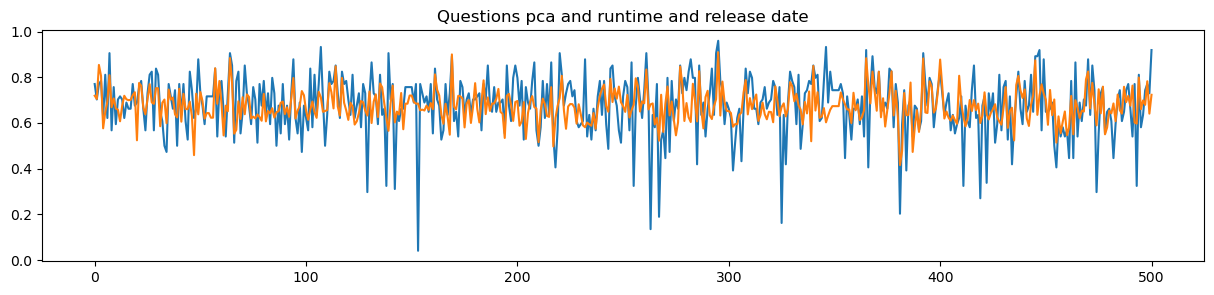

R2 :  0.1866483217396493
RMSE :  0.11830202491982479


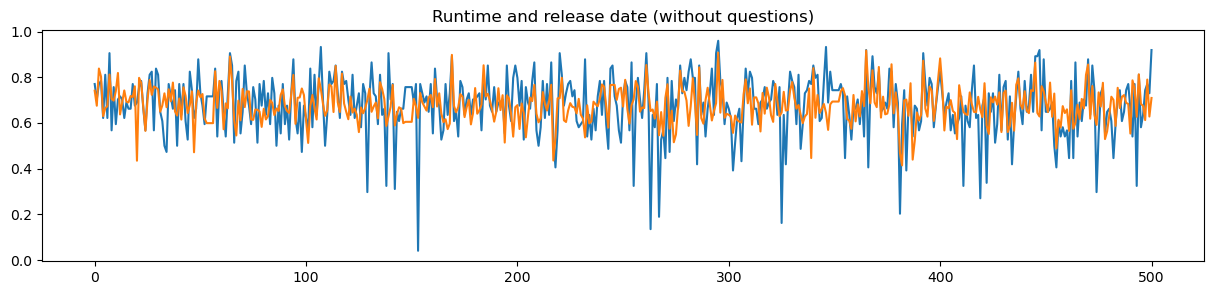

R2 :  0.14640333164927277
RMSE :  0.12119350630013595


In [31]:
# second version : questions + runtime and date (X_df_question_plus, y_df_question_plus)

length = len(y_df_question_plus)
#train_size = int(length*0.8)
train_size = int(length*0.9)
test_size = length - train_size
print(train_size, test_size)
print(length)

regressor.fit(X_df_question_plus[:train_size], y_df_question_plus[:train_size]) #Set train
y_pred = regressor.predict(X_df_question_plus[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question_plus[train_size:])
ax.plot(y_pred)
plt.title('Questions and runtime and release date')
plt.show()

print("R2 : ",regressor.score(X_df_question_plus[train_size:], y_df_question_plus[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question_plus[train_size:], squared=False)
print("RMSE : ", rmse)

#half questions (X_df_half_questions_plus, y_df_question_plus)
regressor.fit(X_df_half_questions_plus[:train_size], y_df_question_plus[:train_size]) #Set train
y_pred = regressor.predict(X_df_half_questions_plus[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question_plus[train_size:])
ax.plot(y_pred)
plt.title('Half questions and runtime and release date')
plt.show()

print("R2 : ",regressor.score(X_df_half_questions_plus[train_size:], y_df_question_plus[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question_plus[train_size:], squared=False)
print("RMSE : ", rmse)

#questions pca (X_df_questions_pca_plus, y_df_question_plus)
regressor.fit(X_df_questions_pca_plus[:train_size], y_df_question_plus[:train_size]) #Set train
y_pred = regressor.predict(X_df_questions_pca_plus[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question_plus[train_size:])
ax.plot(y_pred)
plt.title('Questions pca and runtime and release date')
plt.show()

print("R2 : ",regressor.score(X_df_questions_pca_plus[train_size:], y_df_question_plus[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question_plus[train_size:], squared=False)
print("RMSE : ", rmse)

#without questions (X_df_plus_without_questions, y_df_question_plus)
regressor.fit(X_df_plus_without_questions[:train_size], y_df_question_plus[:train_size]) #Set train
y_pred = regressor.predict(X_df_plus_without_questions[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_question_plus[train_size:])
ax.plot(y_pred)
plt.title('Runtime and release date (without questions)')
plt.show()

print("R2 : ",regressor.score(X_df_plus_without_questions[train_size:], y_df_question_plus[train_size:]))
rmse = mean_squared_error(y_pred, y_df_question_plus[train_size:], squared=False)
print("RMSE : ", rmse)


1450 363
1813


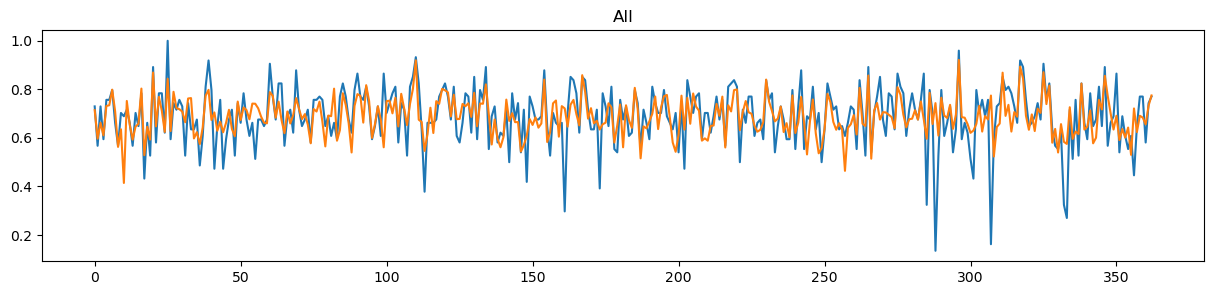

R2 :  0.3509133447000097
RMSE :  0.09601282502251114


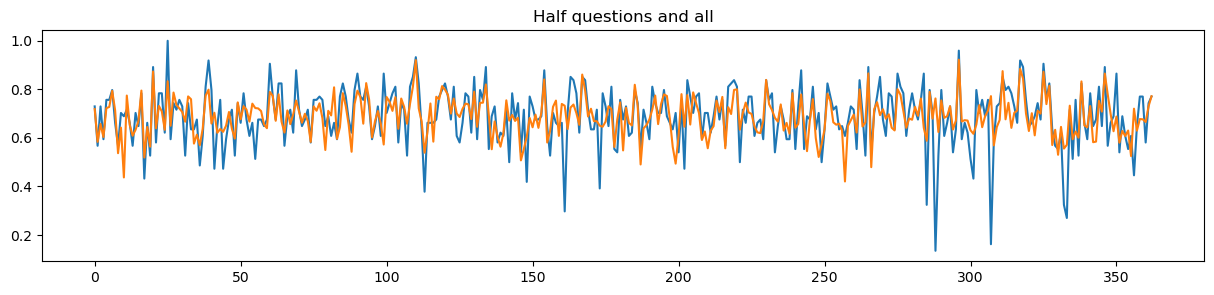

R2 :  0.33628275463082935
RMSE :  0.09708887282736456


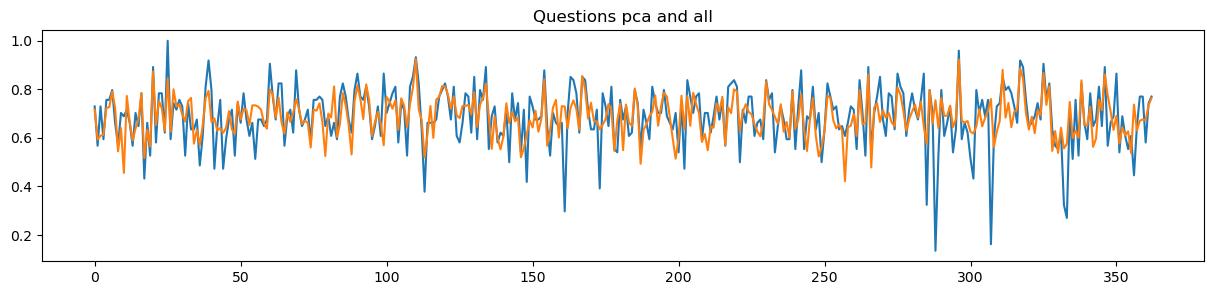

R2 :  0.34918371581814633
RMSE :  0.09614066317101443


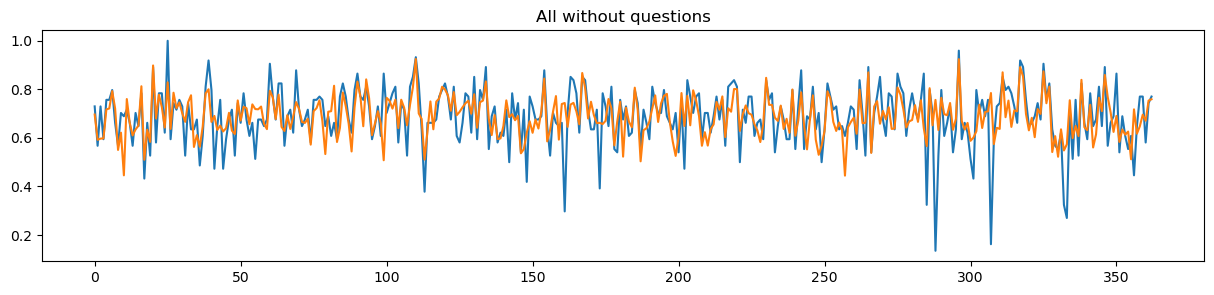

R2 :  0.3252805300995113
RMSE :  0.09789027065630083


In [32]:
# fifth version : all (X_df_all , y_df_all)

length = len(y_df_all)
train_size = int(length*0.8)
test_size = length - train_size
print(train_size, test_size)
print(length)

regressor.fit(X_df_all[:train_size], y_df_all[:train_size]) #Set train
y_pred = regressor.predict(X_df_all[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_all[train_size:])
ax.plot(y_pred)
plt.title('All')
plt.show()

print("R2 : ",regressor.score(X_df_all[train_size:], y_df_all[train_size:]))
rmse = mean_squared_error(y_pred, y_df_all[train_size:], squared=False)
print("RMSE : ", rmse)

#half all (X_df_half_all, y_df_all)
regressor.fit(X_df_half_all[:train_size], y_df_all[:train_size]) #Set train
y_pred = regressor.predict(X_df_half_all[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_all[train_size:])
ax.plot(y_pred)
plt.title('Half questions and all')
plt.show()

print("R2 : ",regressor.score(X_df_half_all[train_size:], y_df_all[train_size:]))
rmse = mean_squared_error(y_pred, y_df_all[train_size:], squared=False)
print("RMSE : ", rmse)

#questions pca (X_df_all_pca, y_df_all)
regressor.fit(X_df_all_pca[:train_size], y_df_all[:train_size]) #Set train
y_pred = regressor.predict(X_df_all_pca[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_all[train_size:])
ax.plot(y_pred)
plt.title('Questions pca and all')
plt.show()

print("R2 : ",regressor.score(X_df_all_pca[train_size:], y_df_all[train_size:]))
rmse = mean_squared_error(y_pred, y_df_all[train_size:], squared=False)
print("RMSE : ", rmse)

#without questions (X_df_all_without_questions, y_df_all)
regressor.fit(X_df_all_without_questions[:train_size], y_df_all[:train_size]) #Set train
y_pred = regressor.predict(X_df_all_without_questions[train_size:]) #Set test

fig, ax = plt.subplots(figsize=(15, 3))
x_val = np.arange(test_size)
ax.plot(x_val, y_df_all[train_size:])
ax.plot(y_pred)
plt.title('All without questions')
plt.show()

print("R2 : ",regressor.score(X_df_all_without_questions[train_size:], y_df_all[train_size:]))
rmse = mean_squared_error(y_pred, y_df_all[train_size:], squared=False)
print("RMSE : ", rmse)


# PCA

> normalized_df_all --> questions, date, vote, runtime, revenu \ 
normalized_df_questions --> questions, date and vote \
normalized_df_questions_only --> questions \
normalized_df_runtime --> questions, date, vote, and runtine \
normalized_df_revenue --> questions, date, vote, and revenu \
normalized_df_no_questions --> date, vote, runtime, revenue \


1, X_df_all (1813, 24) (1813,)
2, X_df_question_plus (5008, 22) (5008,)
3, X_df_question (5008, 20) (5008,)
4, X_df_no_questions (1851, 4) (1851,)
5, X_df_date_vote (5008, 2) (5008,)


In [33]:
from sklearn.decomposition import PCA

## X_df_question

Explained variance ratio :  [0.12099678 0.07314994 0.06530212 0.06428812 0.06057492 0.0574477
 0.05695748 0.05399202 0.04725098 0.04673864 0.04390839 0.0419828
 0.03765588 0.03693246 0.0348309  0.03369304 0.03339088 0.03188151
 0.03101331 0.02801216]
Cumulative explained variance :  [0.12099678 0.19414671 0.25944884 0.32373695 0.38431187 0.44175957
 0.49871704 0.55270906 0.59996004 0.64669869 0.69060707 0.73258988
 0.77024575 0.80717821 0.8420091  0.87570215 0.90909302 0.94097453
 0.97198784 1.        ]


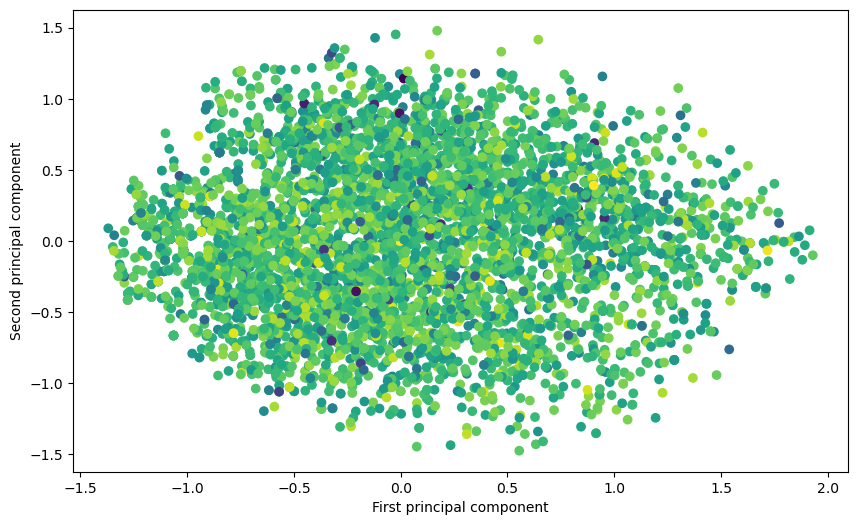

In [34]:
pca = PCA()
data_pca_all = pca.fit_transform(X_df_question)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print('Explained variance ratio : ', explained_variance)

# Cumulative explained variance
cum_explained_variance = np.cumsum(explained_variance)
print('Cumulative explained variance : ', cum_explained_variance)

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(data_pca_all[:, 0], data_pca_all[:, 1], c=y_df_question, )
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [35]:
# Get the loadings (coefficients) for the first principal component
loadings_first_component = pca.components_[0]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_first_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('first component', loadings_df.head(5))

# Get the loadings (coefficients) for the second principal component
loadings_first_component = pca.components_[1]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_first_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('second component', loadings_df.head(5))

# Get the loadings (coefficients) for the third principal component
loadings_third_component = pca.components_[2]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_third_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('third component', loadings_df.head(5))

# Get the loadings (coefficients) for the fourth principal component
loadings_fourth_component = pca.components_[3]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_fourth_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('fourth component', loadings_df.head(5))

# Get the loadings (coefficients) for the fifth principal component
loadings_fifth_component = pca.components_[4]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_fifth_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('fifth component', loadings_df.head(5))

# Get the loadings (coefficients) for the sixth principal component
loadings_sixth_component = pca.components_[5]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_question.columns, 'Loading': loadings_sixth_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('sixth component', loadings_df.head(5))


first component    Variable   Loading
9       q_9  0.446701
10     q_10  0.359301
6       q_6  0.356506
0       q_0  0.342238
16     q_16  0.335609
second component    Variable   Loading
0       q_0  0.630384
1       q_1 -0.407196
16     q_16 -0.405086
13     q_13 -0.250602
14     q_14  0.204047
third component    Variable   Loading
18     q_18  0.631078
13     q_13  0.558903
19     q_19 -0.343042
16     q_16 -0.224073
6       q_6 -0.186148
fourth component    Variable   Loading
13     q_13 -0.417396
1       q_1  0.351964
4       q_4  0.347062
18     q_18  0.293788
0       q_0 -0.289767
fifth component    Variable   Loading
6       q_6 -0.600435
7       q_7  0.537634
4       q_4  0.358136
16     q_16  0.295270
19     q_19  0.200620
sixth component    Variable   Loading
13     q_13  0.444933
16     q_16 -0.433449
7       q_7 -0.378669
18     q_18 -0.354778
9       q_9  0.277922


## X_df_no_questions

Explained variance ratio :  [0.83567625 0.10418172 0.04186707 0.01827496]
Cumulative explained variance :  [0.83567625 0.93985797 0.98172504 1.        ]


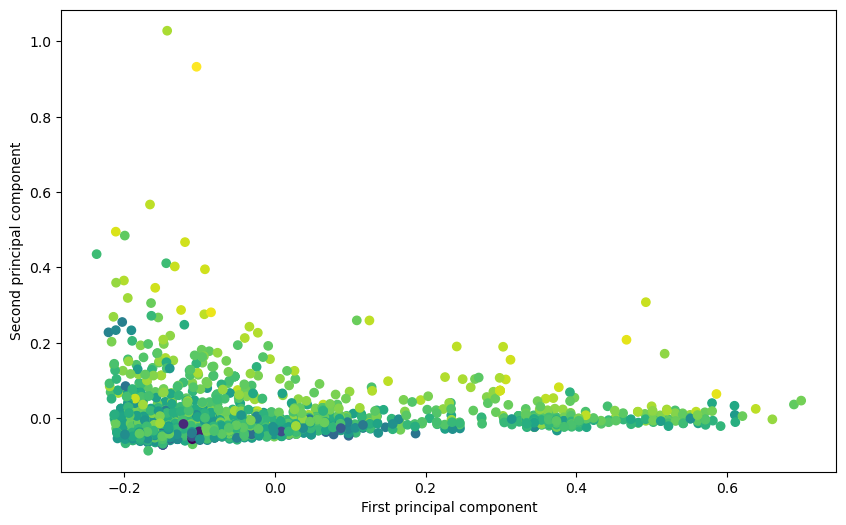

In [36]:
data_pca_all = pca.fit_transform(X_df_all_without_questions)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print('Explained variance ratio : ', explained_variance)

# Cumulative explained variance
cum_explained_variance = np.cumsum(explained_variance)
print('Cumulative explained variance : ', cum_explained_variance)

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(data_pca_all[:, 0], data_pca_all[:, 1], c=y_df_all, )
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [37]:
# Get the loadings (coefficients) for the first principal component
loadings_first_component = pca.components_[0]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_all_without_questions.columns, 'Loading': loadings_first_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('first component', loadings_df.head(5))

# Get the loadings (coefficients) for the second principal component
loadings_first_component = pca.components_[1]

# Create a DataFrame to display the loadings
loadings_df = pd.DataFrame({'Variable': X_df_all_without_questions.columns, 'Loading': loadings_first_component})
# Sort the DataFrame by the absolute values of the loadings
loadings_df['Absolute Loading'] = loadings_df['Loading'].abs()
loadings_df = loadings_df.sort_values(by='Absolute Loading', ascending=False).drop('Absolute Loading', axis=1)

# Display the loadings DataFrame
print('second component', loadings_df.head(5))

first component         Variable   Loading
0  movie_release -0.997145
1       nb_votes -0.057804
3        revenue -0.048130
2        runtime -0.006581
second component         Variable   Loading
1       nb_votes  0.775324
3        revenue  0.567205
2        runtime  0.267697
0  movie_release -0.074090


# Correlation analysis

> normalized_df_questions --> questions, date and vote \
normalized_df_questions_only --> questions \
normalized_df_runtime --> questions, date, vote, and runtine \
normalized_df_revenue --> questions, date, vote, and revenu \
normalized_df_no_questions --> date, vote, runtime, revenue \
normalized_df_all --> questions, date, vote, runtime, revenu 

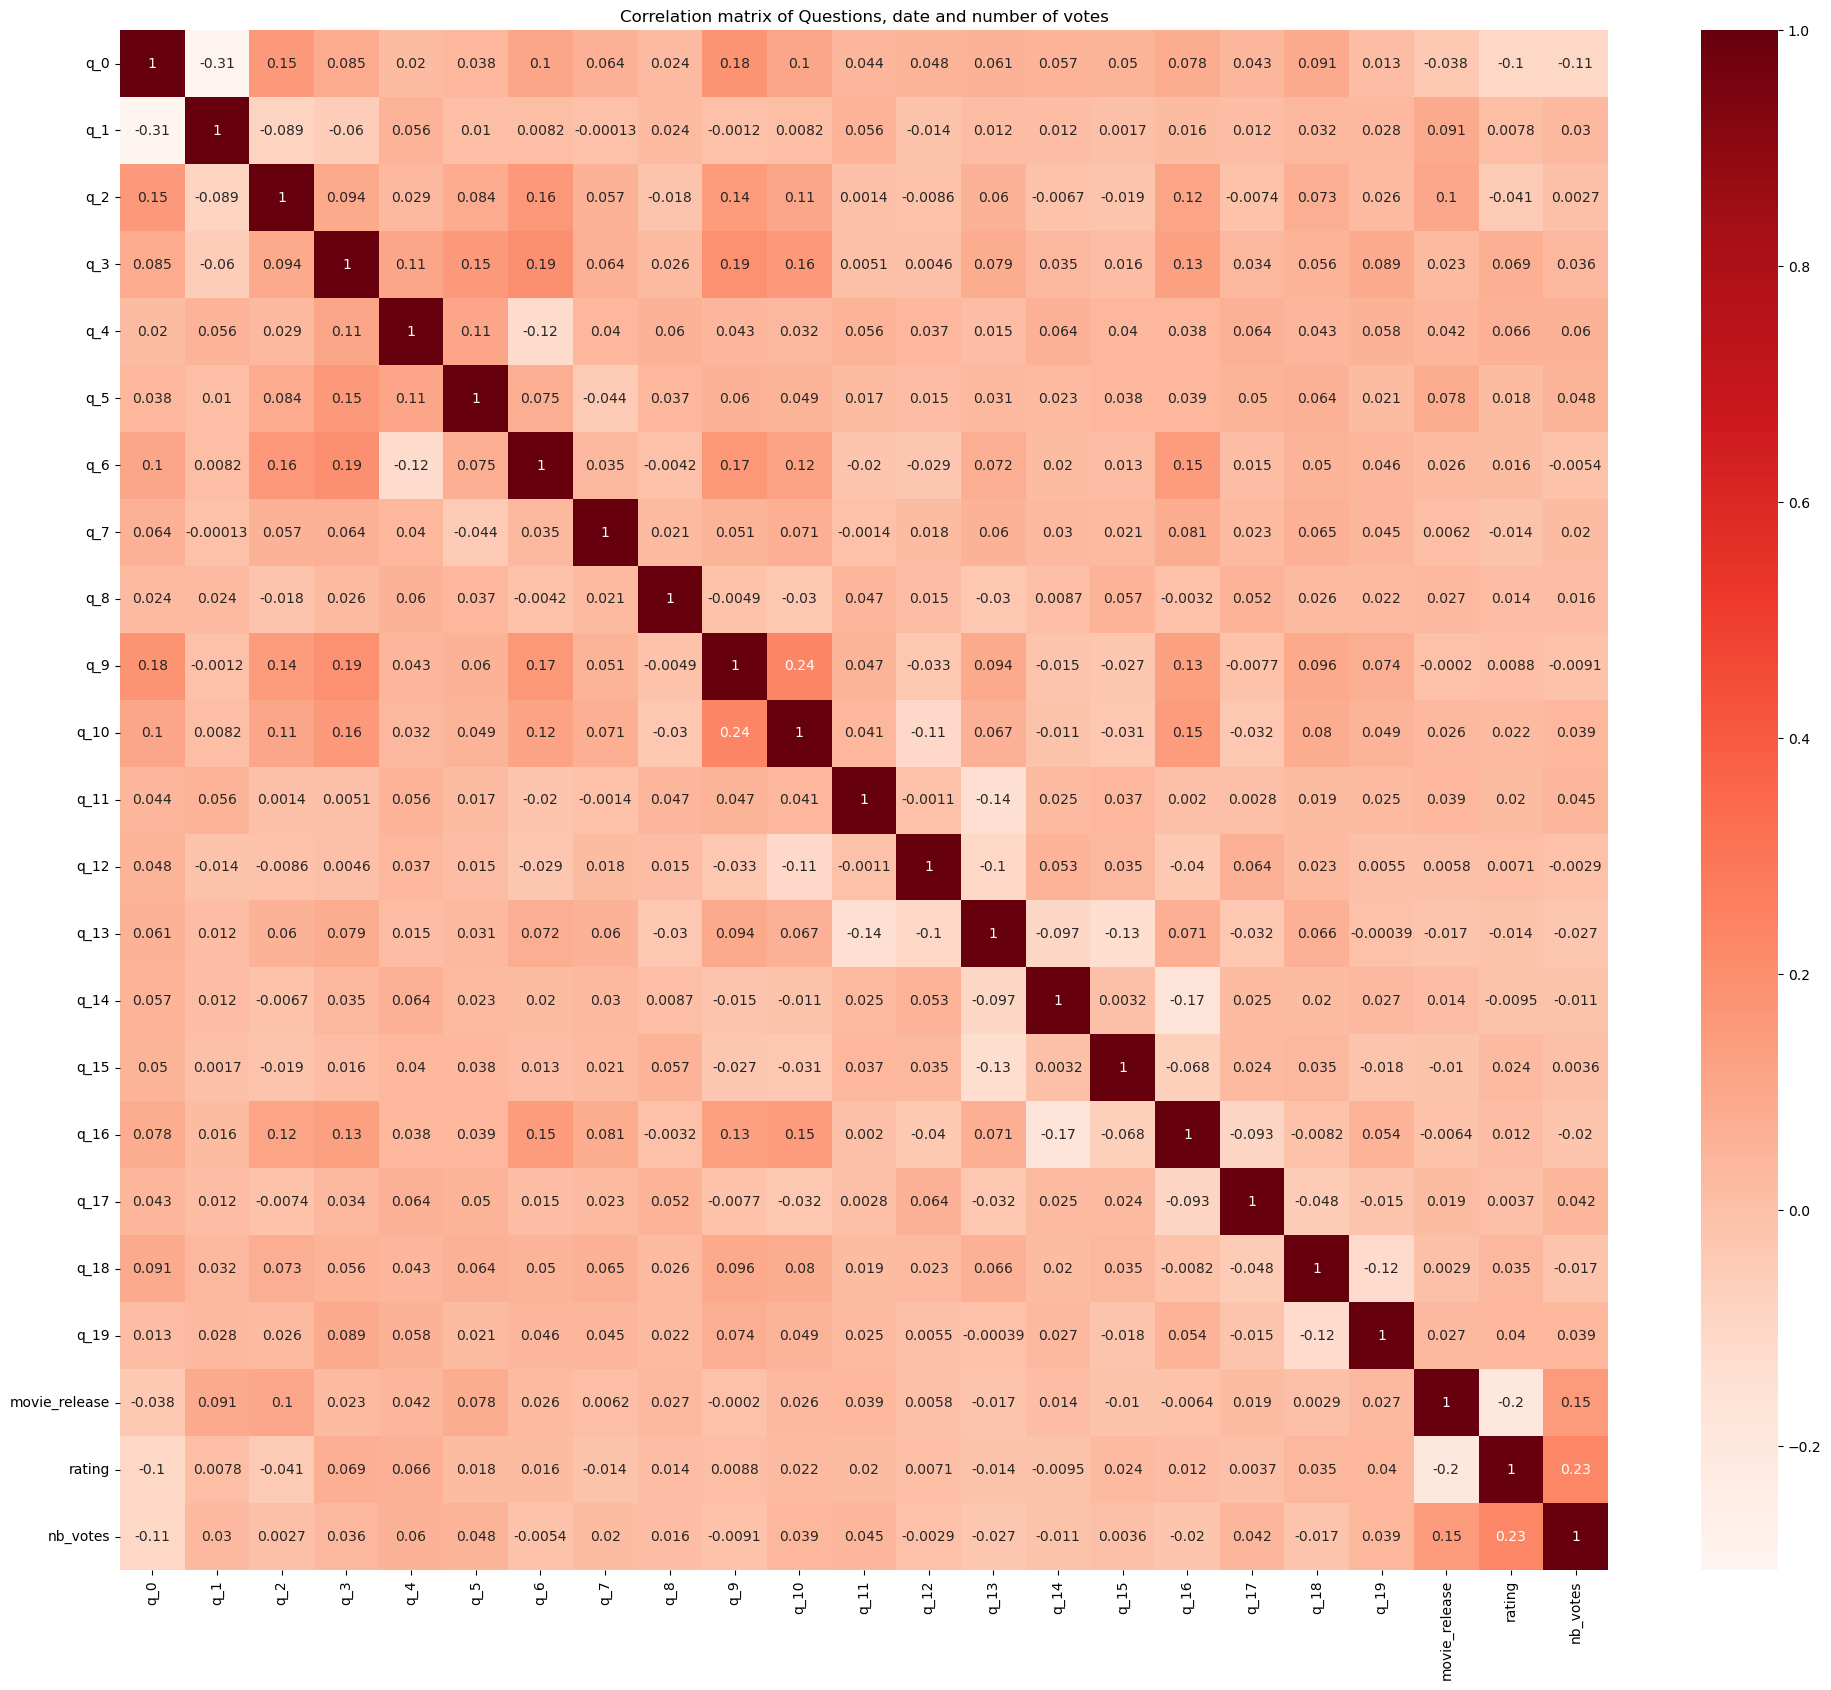

correlation_with_ratings rating           1.000000
nb_votes         0.225921
movie_release    0.202527
q_0              0.104258
q_3              0.069456
q_4              0.065672
q_2              0.041416
q_19             0.039940
q_18             0.034756
q_15             0.024005
q_10             0.022407
q_11             0.020019
q_5              0.017502
q_6              0.016324
q_7              0.014382
q_13             0.014153
q_8              0.013731
q_16             0.012050
q_14             0.009536
q_9              0.008809
q_1              0.007801
q_12             0.007121
q_17             0.003664
Name: rating, dtype: float64


In [74]:
fig, ax = plt.subplots(figsize=(24, 20))
correlation_matrix = normalized_df_questions.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation matrix of Questions, date and number of votes')
plt.show()

# correlation with ratings 
correlation_with_ratings = correlation_matrix['rating']
abs_correlation_with_ratings = abs(correlation_with_ratings).sort_values(ascending=False)
print('correlation_with_ratings', abs_correlation_with_ratings)

# correlation with q0
correlation_with_q0 = correlation_matrix['q_0']
abs_correlation_with_q0 = abs(correlation_with_q0).sort_values(ascending=False)
#print('correlation_with_q0', abs_correlation_with_q0)

Remove features with low correlation or those that are highly correlated with each other (to avoid multicollinearity)

# Recursive Feature Elimination (RFE)

In [39]:
from sklearn.linear_model import LinearRegression

model0 = LinearRegression() # Create a model (maybe try other models later)

In [40]:
num_features_to_select = 5  # adjust this
rfe_question_only = RFE(model0, n_features_to_select=num_features_to_select)

# Fit the RFE model to your data
rfe_question_only.fit(X_df_question, y_df_question)
# Get the selected features
selected_features_question_only = rfe_question_only.support_

# Print the ranking of features
print("Feature Ranking for question only:", rfe_question_only.ranking_)

# Use the selected features for further analysis
selected_X_question_only = X_df_question.loc[:, selected_features_question_only]

# Print the selected features
print("Selected features for question only:", selected_X_question_only.columns)

Feature Ranking for question only: [ 1  3  2  1  1 16  6  8 11 14  7  5  9 13 10  4 12 15  1  1]
Selected features for question only: Index(['q_0', 'q_3', 'q_4', 'q_18', 'q_19'], dtype='object')


In [41]:
num_features_to_select = 7  # adjust this

rfe_question_plus = RFE(model0, n_features_to_select=num_features_to_select)

# Fit the RFE model to your data
rfe_question_plus.fit(X_df_question_plus, y_df_question_plus)
# Get the selected features
selected_features_question_plus = rfe_question_plus.support_

# Print the ranking of features
print("Feature Ranking for question plus:", rfe_question_plus.ranking_)

# Use the selected features for further analysis
selected_X_question_plus = X_df_question_plus.loc[:, selected_features_question_plus]

# Print the selected features
print("Selected features for question plus:", selected_X_question_plus.columns)

Feature Ranking for question plus: [ 1  7  6  1  1 12  3  4 10 15  9  5  8 13 14  2 11 16  1  1  1  1]
Selected features for question plus: Index(['q_0', 'q_3', 'q_4', 'q_18', 'q_19', 'movie_release', 'nb_votes'], dtype='object')


In [42]:
num_features_to_select = 7  # adjust this
#num_features_to_select = 9  # adjust this


rfe_all = RFE(model0, n_features_to_select=num_features_to_select)

# Fit the RFE model to your data
rfe_all.fit(X_df_all, y_df_all)
# Get the selected features
selected_features_all = rfe_all.support_

# Print the ranking of features
print("Feature Ranking for all:", rfe_all.ranking_)
# Use the selected features for further analysis
selected_X_all = X_df_all.loc[:, selected_features_all]

# Print the selected features
print("Selected features for all:", selected_X_all.columns)

Feature Ranking for all: [ 1 13 12  8  4  1  2  5 18 17 10  9  3 14 15 16  7 11  6  1  1  1  1  1]
Selected features for all: Index(['q_0', 'q_5', 'q_19', 'movie_release', 'nb_votes', 'runtime',
       'revenue'],
      dtype='object')


Si on rajoute les autres paramètres, les questions importantes changent --> je pense que c'est du au fait qu'on drop pas mal de ligne au passage pour ne plus avoir de nan

# Mutual information

In [43]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


If only questions :


In [52]:
X_train_question, X_test_question, y_train_question, y_test_question = train_test_split(X_df_question, y_df_question, test_size=0.2, random_state=1)
# Compute mutual information for regression
mi_scores_regression_question = mutual_info_regression(X_train_question, y_train_question)

print("Mutual Information Scores:")
print('len:', len(mi_scores_regression_question))
print(mi_scores_regression_question)

print(X_df_question.columns)

Mutual Information Scores:
len: 20
[0.         0.         0.00810662 0.         0.         0.
 0.00218831 0.01270957 0.         0.00655672 0.         0.
 0.         0.01199684 0.         0.         0.         0.00548061
 0.00392239 0.00224816]
Index(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
       'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18',
       'q_19'],
      dtype='object')


In [59]:
X_train_question_plus, X_test_question_plus, y_train_question_plus, y_test_question_plus = train_test_split(X_df_question_plus, y_df_question_plus, test_size=0.2, random_state=42)
# Compute mutual information for regression
mi_scores_regression_question_plus = mutual_info_regression(X_train_question_plus, y_train_question_plus)

print("Mutual Information Scores:")
print('len:', len(mi_scores_regression_question_plus))
print(mi_scores_regression_question_plus)

print(X_df_question_plus.columns)


Mutual Information Scores:
len: 22
[0.         0.         0.         0.         0.00865927 0.00417037
 0.00079247 0.         0.00053545 0.         0.00730921 0.01489848
 0.0089768  0.01703911 0.         0.00927736 0.01163034 0.
 0.         0.         0.06953462 0.16881577]
Index(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
       'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18',
       'q_19', 'movie_release', 'nb_votes'],
      dtype='object')


In [60]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_df_all, y_df_all, test_size=0.2, random_state=42)
# Compute mutual information for regression
mi_scores_regression_all = mutual_info_regression(X_train_all, y_train_all)

print("Mutual Information Scores:")
print('len:', len(mi_scores_regression_all))
print(mi_scores_regression_all)

print(X_df_all.columns)

Mutual Information Scores:
len: 24
[0.02539503 0.         0.02006441 0.         0.         0.01187003
 0.01162431 0.01956376 0.         0.01002599 0.00469892 0.
 0.         0.00066183 0.         0.         0.01027405 0.
 0.         0.         0.0549018  0.17658794 0.10909237 0.07328019]
Index(['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9',
       'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18',
       'q_19', 'movie_release', 'nb_votes', 'runtime', 'revenue'],
      dtype='object')


# LASSO Regression (L1 Regularization)

In [61]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Coefficients: [-0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0.]
Intercept: 0.6774331745624806
(1002,) (1002,)
Mean Squared Error: 0.01456530999307645


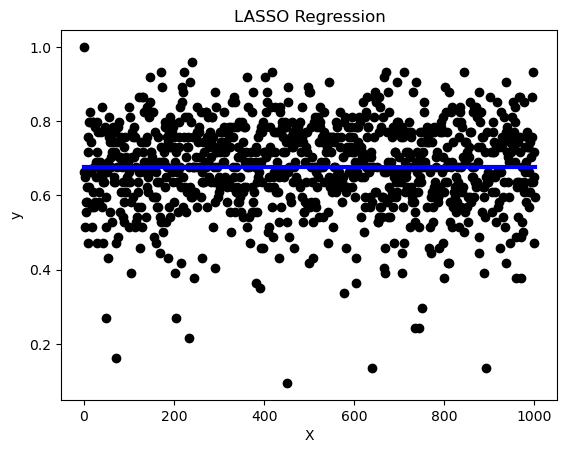

In [71]:
# Standardize the features (important for regularization)
scaler = StandardScaler()
X_train_scaled_question = scaler.fit_transform(X_train_question)
X_test_scaled_question = scaler.transform(X_test_question)

# Create and train the Lasso regression model
alpha = 0.1  # Regularization parameter (you may need to tune this)
alpha = 0.6
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_scaled_question, y_train_question)

# Make predictions on the test set
y_pred_question = lasso_reg.predict(X_test_scaled_question)

# Print the coefficients and intercept
print("Coefficients:", lasso_reg.coef_)
print("Intercept:", lasso_reg.intercept_)

print(np.shape(y_pred_question), np.shape(y_test_question))

# Evaluate the model
mse = mean_squared_error(y_test_question, y_pred_question)
print("Mean Squared Error:", mse)

x_val = np.arange(len(y_test_question))

# Plot the results
plt.scatter(x_val, y_test_question, color='black')
plt.plot(x_val, y_pred_question, color='blue', linewidth=3)
plt.title("LASSO Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Coefficients: [-0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.
  0.  0. -0.  0.]
Intercept: 0.6771396958616129
(1002,) (1002,)
Mean Squared Error: 0.01670555751881019


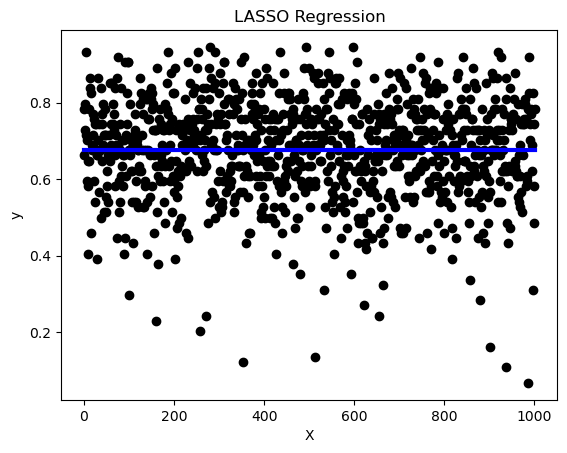

In [72]:
# Standardize the features (important for regularization)
scaler = StandardScaler()
X_train_scaled_question_plus = scaler.fit_transform(X_train_question_plus)
X_test_scaled_question_plus = scaler.transform(X_test_question_plus)

# Create and train the Lasso regression model
lasso_reg.fit(X_train_scaled_question_plus, y_train_question_plus)

# Make predictions on the test set
y_pred_question_plus = lasso_reg.predict(X_test_scaled_question_plus)

# Print the coefficients and intercept
print("Coefficients:", lasso_reg.coef_)
print("Intercept:", lasso_reg.intercept_)

print(np.shape(y_pred_question_plus), np.shape(y_test_question_plus))

# Evaluate the model
mse = mean_squared_error(y_test_question_plus, y_pred_question_plus)
print("Mean Squared Error:", mse)

x_val = np.arange(len(y_test_question_plus))

# Plot the results
plt.scatter(x_val, y_test_question_plus, color='black')
plt.plot(x_val, y_pred_question_plus, color='blue', linewidth=3)
plt.title("LASSO Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Coefficients: [-0.  0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0.  0. -0.
  0.  0. -0.  0.  0.  0.]
Intercept: 0.6818825722273998
(363,) (363,)
Mean Squared Error: 0.014722305414219507


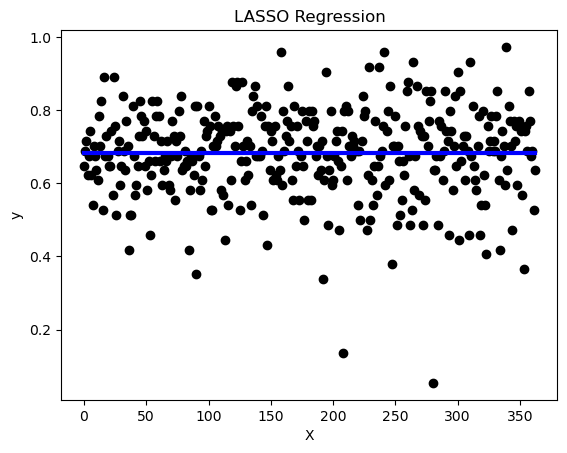

In [73]:
# Standardize the features (important for regularization)
X_train_scaled_all = scaler.fit_transform(X_train_all)
X_test_scaled_all = scaler.transform(X_test_all)

# Create and train the Lasso regression model
lasso_reg.fit(X_train_scaled_all, y_train_all)

# Make predictions on the test set
y_pred_all = lasso_reg.predict(X_test_scaled_all)

# Print the coefficients and intercept
print("Coefficients:", lasso_reg.coef_)
print("Intercept:", lasso_reg.intercept_)

print(np.shape(y_pred_all), np.shape(y_test_all))

# Evaluate the model
mse = mean_squared_error(y_test_all, y_pred_all)
print("Mean Squared Error:", mse)

x_val = np.arange(len(y_test_all))

# Plot the results
plt.scatter(x_val, y_test_all, color='black')
plt.plot(x_val, y_pred_all, color='blue', linewidth=3)
plt.title("LASSO Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()